In [1]:
import gzip
import shutil
import requests
import pandas as pd
import csv
from io import StringIO
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np




In [2]:
def download_file(output_file):
    url = 'https://datasets.imdbws.com/'+output_file+'.tsv.gz'
    response = requests.get(url)

    if response.status_code == 200:
        with open(output_file+'.tsv.gz', 'wb') as f:
            f.write(response.content)
            
    else:
        print('Request failed with status code:', response.status_code)

def open_file(output_file):
    file = output_file+'.tsv.gz'
    with gzip.open(file, 'rt', encoding='utf-8') as gz_file:
        df = pd.read_csv(gz_file, delimiter='\t')    

    return df

In [3]:
def findMovies(titles = None,
               maxyear= float(2024),
                minyear= float(1900),
                mxRuntime= float(300),
                genres = None,
                Votes = float(0),
                minRating= float(0),
                kidsFriendly = False,
                English = True,
                Blocbuster = False,
                downloadIMDB = True):
    
    def filterAgeRating(df):
        if kidsFriendly:
            df = df[df['ageRating'] == 'G']
        return df



    
    if titles is None:
        print("Please provide the 'titles' dataframe.")
        print("Usage: findMovies(titles, maxyear, minyear, mxRuntime, genres, Votes, minRating, kidsFriendly, English, Blocbuster, downloadIMDB)")
        return


    else:
        if downloadIMDB:
            for file in ['title.basics', 'title.ratings']:
                print('Downloading', file)
                download_file(file)
        else:
            print('Using locally available data')
        
        
        if downloadIMDB:
            for file in ['title.basics', 'title.ratings']:
                print('Downloading', file)
                download_file(file)
        else:
            print('Using local available data')



    


In [4]:
output_file = 'title.basics'
output_file = 'title.ratings'
output_file = 'title.crew'
output_file = 'name.basics'
output_file = 'title.principals'
#download_file(output_file)

In [ ]:
titles = open_file('title.basics')
print('loaded titles')
ratings = open_file('title.ratings')
print('loaded ratings')
crew = open_file('title.crew')
print('loaded crew')
names = open_file('name.basics')
print('loaded names')
names = names.iloc[:, :2]



In [7]:
titles = titles[titles['titleType'] == 'movie']

titles = titles.drop(['titleType','isAdult','endYear',], axis=1)

titles = titles.merge(ratings, on='tconst', how='inner')
titles = titles.merge(crew, on='tconst', how='inner')

del ratings
del crew

titles = titles[titles['startYear'] != '\\N']
titles = titles[titles['runtimeMinutes'] != '\\N']
titles = titles[titles['numVotes'] != '\\N']

In [26]:
names_dict = names.set_index('nconst')['primaryName'].to_dict()



In [56]:
person_name = 'Martin Scorsese'


person = next((key for key, value in names_dict.items() if value == person_name), None)
if person is None:
    print(f"Person '{person_name}' not found.")
else:
    print(f"The key for '{person_name}' is: {person}")

The key for 'Martin Scorsese' is: nm0000217


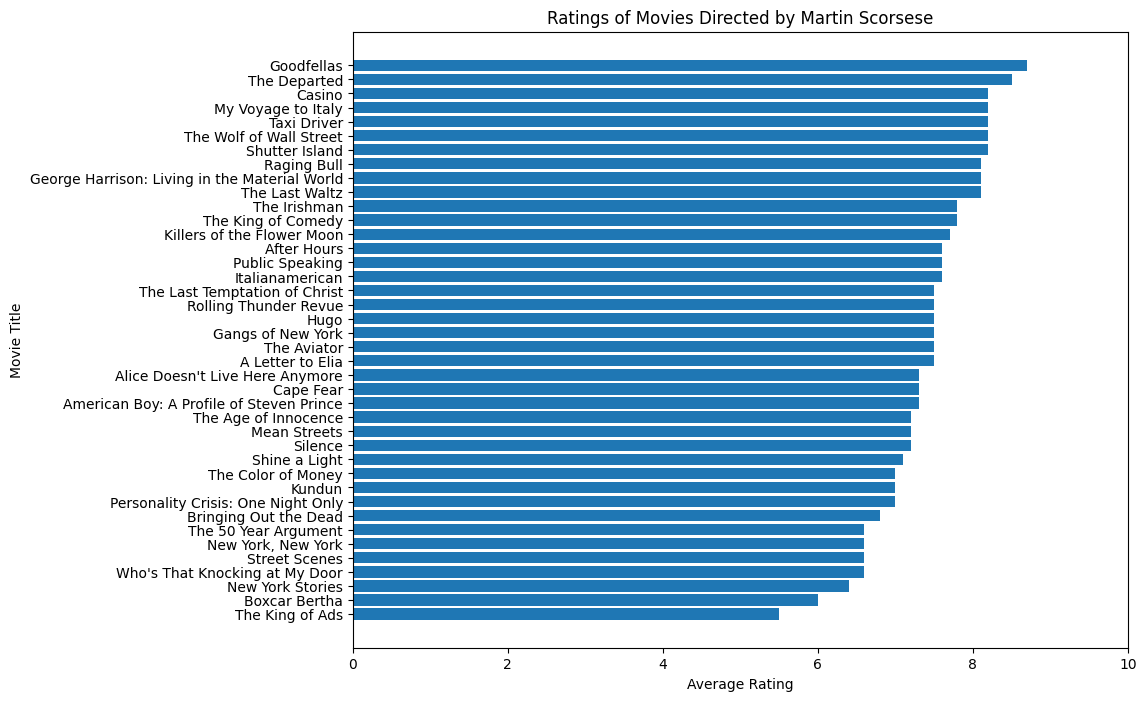

In [57]:
filtered_titles = titles[titles['directors'].str.contains(person)]
filtered_titles_sorted = filtered_titles.sort_values('averageRating', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figsize as per your preference
ax.barh(filtered_titles_sorted['primaryTitle'], filtered_titles_sorted['averageRating'])
ax.set_title(f'Ratings of Movies Directed by {person_name}')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Movie Title')
ax.set_xlim(0, 10)
plt.show()


In [150]:
unique_title_types = titles['titleType'].unique()
print(unique_title_types)


titles['startYear'] = titles['startYear'].astype(int)
titles['runtimeMinutes'] = titles['runtimeMinutes'].astype(int)
titles['numVotes'] = titles['numVotes'].astype(int)


current_year = datetime.now().year
titles = titles[titles['startYear'] <= current_year]

#titles = titles[titles['genres'].str.contains('Adventure')]
titles.shape



['short' 'movie' 'tvShort' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame']


(274811, 11)

In [176]:
titles = titles[titles['numVotes'] >= 100000]
titles.shape
titles = titles[titles['primaryTitle'] == titles['originalTitle']]
titles.shape


(2245, 11)

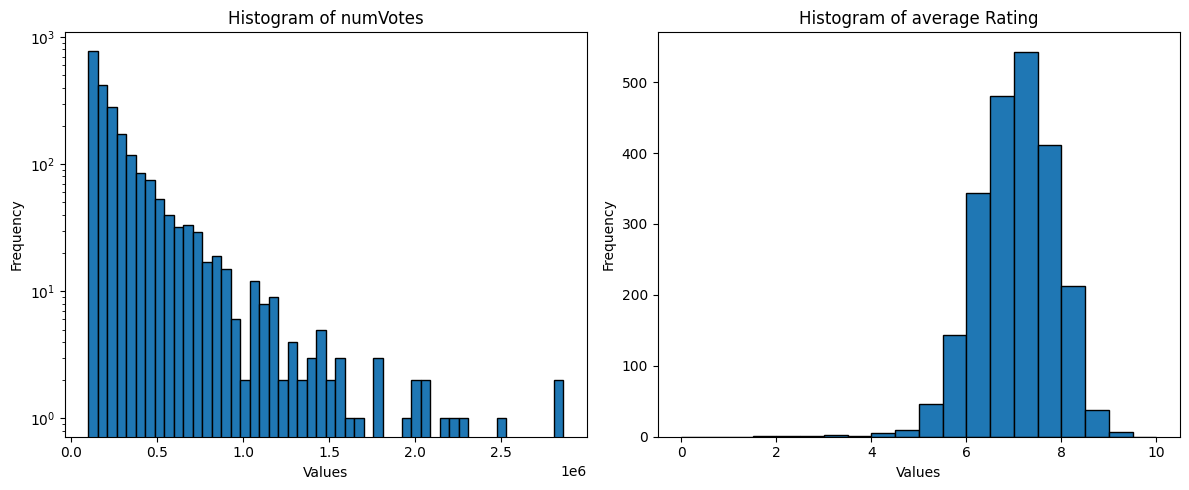

In [179]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

num_bins = 10
# Plotting the first histogram
axs[0].hist(titles['numVotes'], bins=50, edgecolor='black', log=True)
axs[0].set_title('Histogram of numVotes')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')

# Plotting the second histogram
axs[1].hist(titles['averageRating'], bins=20, edgecolor='black', log=False, range = (0,10))
axs[1].set_title('Histogram of average Rating')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

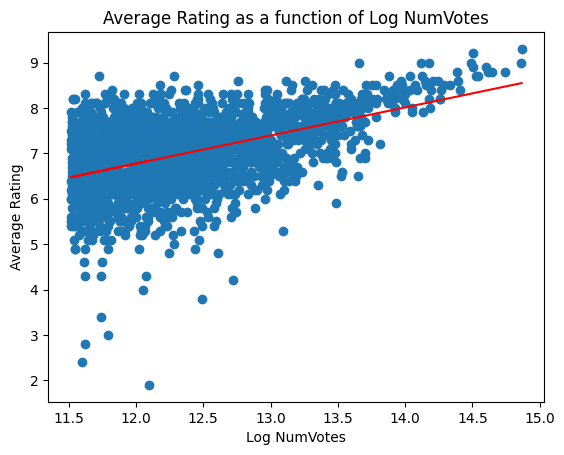

In [227]:
from sklearn.linear_model import LinearRegression


plt.scatter(np.log(titles['numVotes']), titles['averageRating'])
plt.title('Average Rating as a function of Log NumVotes')
plt.xlabel('Log NumVotes')
plt.ylabel('Average Rating')

X = np.log(titles['numVotes']).values.reshape(-1, 1)
y = titles['averageRating'].values

model = LinearRegression()
model.fit(X, y)

plt.plot(X, model.predict(X), color='red', label='Linear Regression')

plt.show()

In [222]:
#titles = titles.sort_values(by='startYear', ascending=False)
#titles = titles.sort_values(by='numVotes', ascending=False)
#titles = titles.sort_values(by='averageRating', ascending=False)
titles = titles.sort_values(by=['averageRating','numVotes','startYear'], ascending=[False, False, False])


In [58]:
titles.iloc[0:20]

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
0,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance,5.3,209,nm0085156,nm0085156
1,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport",5.2,500,nm0714557,\N
2,tt0000502,Bohemios,Bohemios,1905,100,\N,4.0,16,nm0063413,"nm0063413,nm0657268,nm0675388"
3,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",6.0,868,nm0846879,nm0846879
4,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.0,22,nm0141150,nm0141150
5,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908,120,"Adventure,Fantasy",5.0,70,"nm0091767,nm0877783","nm0000875,nm0877783"
6,tt0000941,Locura de amor,Locura de amor,1909,45,Drama,4.5,27,"nm0063413,nm0550220","nm0063413,nm0550220,nm0848502"
7,tt0001184,Don Juan de Serrallonga,Don Juan de Serrallonga,1910,58,"Adventure,Drama",3.8,22,"nm0063413,nm0550220",nm0049370
8,tt0001285,The Life of Moses,The Life of Moses,1909,50,"Biography,Drama,Family",5.4,60,nm0085865,"nm0676645,nm0836316"
9,tt0001498,The Battle of Trafalgar,The Battle of Trafalgar,1911,51,War,7.8,14,nm0205986,\N


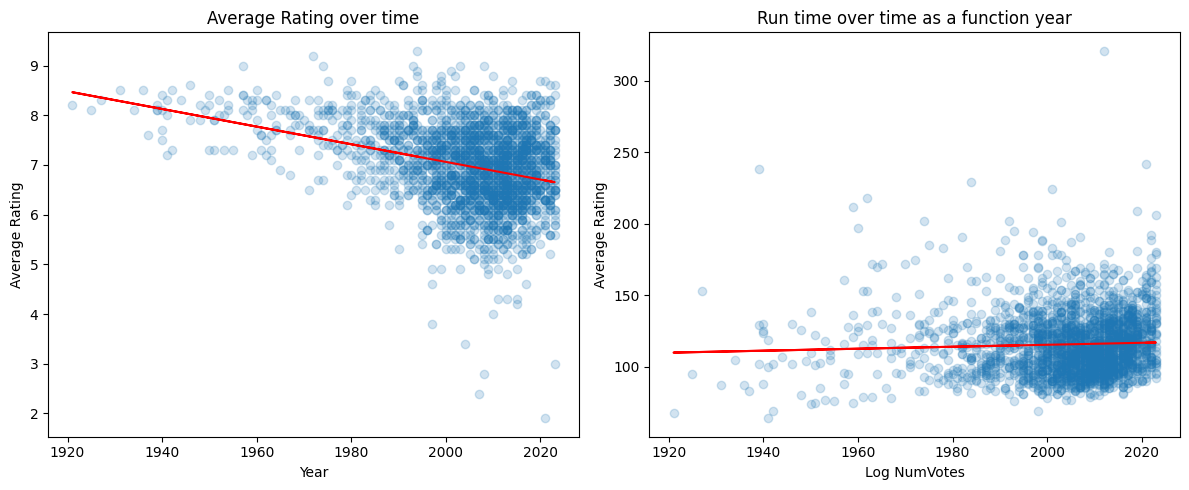

In [275]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(titles['startYear'], titles['averageRating'],alpha=0.2)
axs[0].set_title('Average Rating over time')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Average Rating')
X = titles['startYear'].values.reshape(-1, 1)
y = titles['averageRating'].values
model = LinearRegression()
model.fit(X, y)
axs[0].plot(X, model.predict(X), color='red', label='Linear Regression')


axs[1].scatter(titles['startYear'], titles['runtimeMinutes'],alpha=0.2)
axs[1].set_title('Run time over time as a function year')
axs[1].set_xlabel('Log NumVotes')
axs[1].set_ylabel('Average Rating')
X = titles['startYear'].values.reshape(-1, 1)
y = titles['runtimeMinutes'].values
model = LinearRegression()
model.fit(X, y)
axs[1].plot(X, model.predict(X), color='red', label='Linear Regression')

plt.tight_layout()

# Show the plots
plt.show()


['Drama', 'Crime', 'Action', 'Adventure', 'Biography', 'History', 'Sci-Fi', 'Romance', 'Fantasy', 'Mystery', 'Thriller', 'War', 'Family', 'Animation', 'Western', 'Comedy', 'Music', 'Horror', 'Film-Noir', 'Musical', 'Sport', 'Documentary']


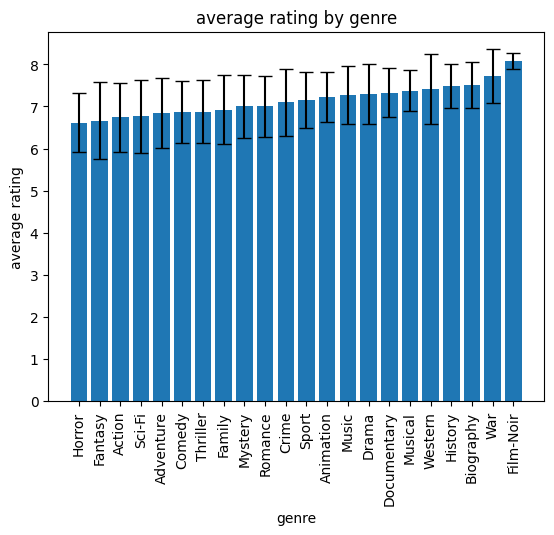

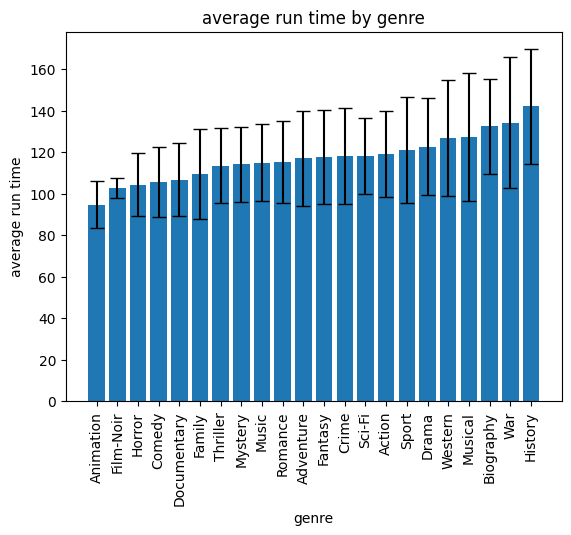

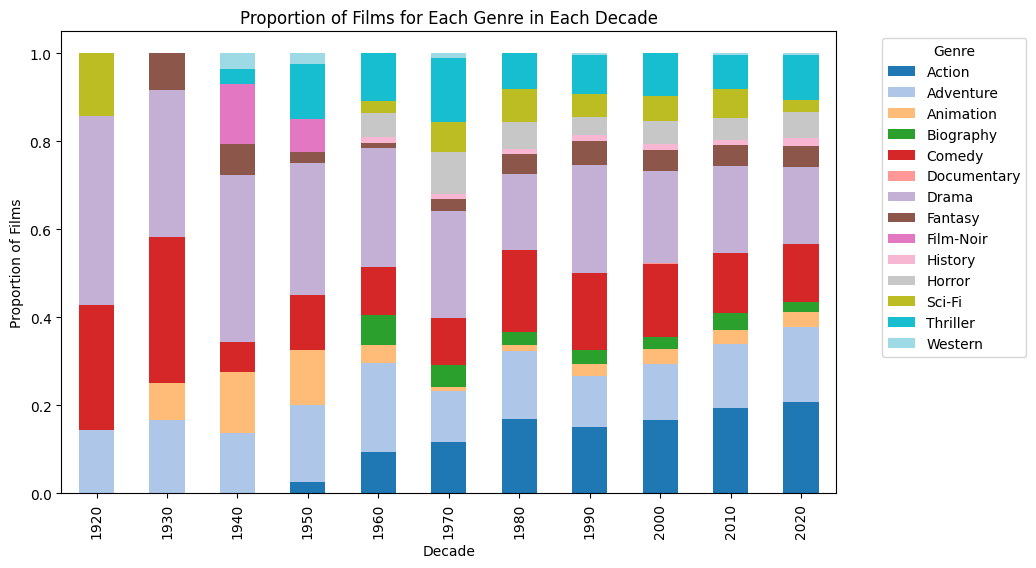

In [274]:
import copy

test = copy.deepcopy(titles)
test['genres'] = test['genres'].str.split(',')
test = test.explode('genres')

unique_values_list = test['genres'].unique().tolist()
print(unique_values_list)

grouped_data = test.groupby('genres')['averageRating'].agg(['mean', 'std'])

# Sorting in ascending order
grouped_data = grouped_data.sort_values(by='mean')

# Plotting with error bars
plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
plt.title('average rating by genre')
plt.xlabel('genre')
plt.ylabel('average rating')
plt.xticks(rotation='vertical')
plt.show()

grouped_data = test.groupby('genres')['runtimeMinutes'].agg(['mean', 'std'])

# Sorting in ascending order
grouped_data = grouped_data.sort_values(by='mean')

# Plotting with error bars
plt.bar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], capsize=5)
plt.title('average run time by genre')
plt.xlabel('genre')
plt.ylabel('average run time')
plt.xticks(rotation='vertical')
plt.show()

genres_to_filter = ['Drama', 'Action', 'Adventure', 'Biography', 
                    'History', 'Sci-Fi', 'Fantasy',
                      'Thriller', 'Animation', 'Western',
                        'Comedy', 'Horror', 'Film-Noir',
                          'Documentary']


test = test[test['genres'].isin(genres_to_filter)]


test['decade'] = (test['startYear'] // 10) * 10
# Step 2: Count the number of films for each combination of decade and genre
decade_genre_counts = test.groupby(['decade', 'genres']).size().unstack(fill_value=0)

# Step 3: Normalize the data
normalized_counts = decade_genre_counts.div(decade_genre_counts.sum(axis=1), axis=0)

# Step 4: Plot the stacked histogram
normalized_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title('Proportion of Films for Each Genre in Each Decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of Films')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [226]:
#save list to csv
titles.to_csv('titles.csv', index=False)